Student Details

Name: Sean McNamara

ID: 20329733

### Task 1

Study the example notebook CS5062 - Lab 4 - Comparison of Binary Classifiers.ipynb and watch the video playlist CS5062-E-tivity4

### Lab 4: Comparison of Binary Classifiers

### Task 2

In this exercise we use Measurements of geometrical properties of kernels belonging to three different varieties of wheat. A soft X-ray technique and GRAINS package were used to construct all seven, real-valued attributes. dataset (see https://archive.ics.uci.edu/ml/datasets/seeds). All columns in this dataset are numerical except the column diagnosis which is ordinal. Each example is measurements of geometrical properties of kernels belonging to three different varieties of wheat. A soft X-ray technique and GRAINS package were used to construct all seven, real-valued attributes.

High quality visualization of the internal kernel structure was detected using a soft X-ray technique. It is non-destructive and considerably cheaper than other more sophisticated imaging techniques like scanning microscopy or laser technology. 

The images were recorded on 13x18 cm X-ray KODAK plates. Studies were conducted using combine harvested wheat grain originating from experimental fields, explored at the Institute of Agrophysics of the Polish Academy of Sciences in Lublin.

In the process of training the dataset will be split into a training set and a test set. The training set will be further split (multiple times) into a training and validation set in a cross-validation procedure for tuning the parameters of two alternative classifiers: SVM and Random Forest.

Note that any data preparation of the predictors needs to be applied separately to each of these sets.

In [44]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

### EDA - Exploratory Data Analysis

From here, it is important to read the data set and check the headers to familarise yourself with the data in question. 

In [45]:
df = pd.read_csv("./seeds.csv")
df.head()

area  perimeter  compactness  length of kernel  width of kernel  \
0  15.26      14.84       0.8710             5.763            3.312   
1  14.88      14.57       0.8811             5.554            3.333   
2  14.29      14.09       0.9050             5.291            3.337   
3  13.84      13.94       0.8955             5.324            3.379   
4  16.14      14.99       0.9034             5.658            3.562   

   asymmetry coefficient  length of kernel groove  type  
0                  2.221                    5.220     1  
1                  1.018                    4.956     1  
2                  2.699                    4.825     1  
3                  2.259                    4.805     1  
4                  1.355                    5.175     1

The same will apply for the tail of the data. 

In [15]:
df.tail()

area  perimeter  compactness  length of kernel  width of kernel  \
205  12.19      13.20       0.8783             5.137            2.981   
206  11.23      12.88       0.8511             5.140            2.795   
207  13.20      13.66       0.8883             5.236            3.232   
208  11.84      13.21       0.8521             5.175            2.836   
209  12.30      13.34       0.8684             5.243            2.974   

     asymmetry coefficient  length of kernel groove  type  
205                  3.631                    4.870     3  
206                  4.325                    5.003     3  
207                  8.315                    5.056     3  
208                  3.598                    5.044     3  
209                  5.637                    5.063     3

In [8]:
df['type'].value_counts()

3    70
2    70
1    70
Name: type, dtype: int64

Now lets take a look at the min below, which gives us the value that is less than or equal to all other values in our set of data.

In [6]:
df.min()

area                       10.5900
perimeter                  12.4100
compactness                 0.8081
length of kernel            4.8990
width of kernel             2.6300
asymmetry coefficient       0.7651
length of kernel groove     4.5190
type                        1.0000
dtype: float64

Why I chose the max next is to gather the whole total and to identify potential outliers. 
From my first observation the "area" & "perimeter" would be my guess. 

In [7]:
df.max()

area                       21.1800
perimeter                  17.2500
compactness                 0.9183
length of kernel            6.6750
width of kernel             4.0330
asymmetry coefficient       8.4560
length of kernel groove     6.5500
type                        3.0000
dtype: float64

From here lets take a look of all the missing values.

In [25]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

This data as a result, has no missing values.

Let's check the boxplots of the numerical columns for outliers. We will do this in various slices.

For the first boxplot below I used "area" & "length of kernel groove".   

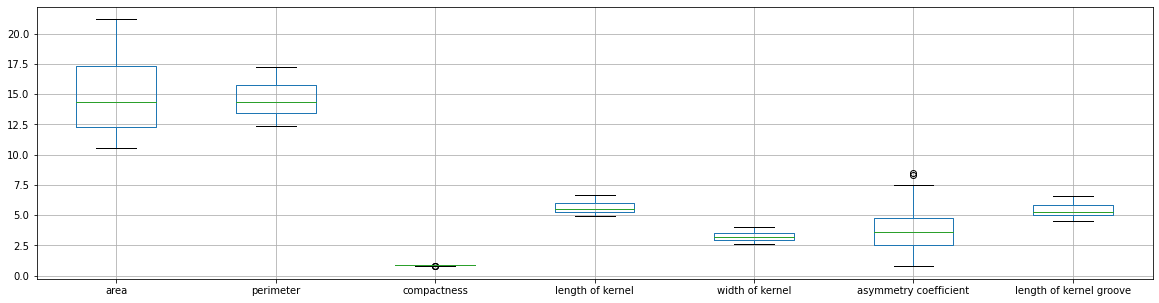

In [11]:
df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

From the data above it seems that my original proposal has changed and that "compactness" & "asymmetry coefficient" seem to carry the outliers. 

Now we can do a boxplot specifically on these colunms. 

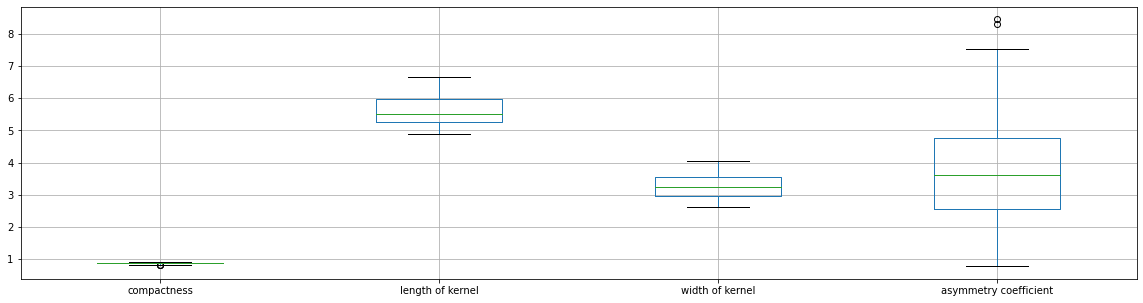

In [12]:
df.loc[:,'compactness':'asymmetry coefficient'].boxplot(figsize=(20,5))
plt.show()

### Data Preparation

We will attempt training SVM and Random Forest classifiers. We will tune their parameters, compare them and choose the best classifier for our problem. Here we will prepare a scikit-learn pipeline for data preparation (preprocessing pipeline), which we will apply later. The use of the pipelines ensures that preprocessing is applied separately to any training validation and test dataset without data leakage.

In [46]:
mapper = {1:0, 2:0, 3:1}
df['type'] = df['type'].replace(mapper)
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

Below we will store a list with the names of all predictors so that we have them in a list to merge back on to the split dataset & define column with the same preparation. 

In [47]:
names_all = [c for c in df if c not in ['type']]
print("column names",names_all)



names_outliers = ['compactness', 'asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))
print("outliers:",names_outliers)

column names ['area', 'perimeter', 'compactness', 'length of kernel', 'width of kernel', 'asymmetry coefficient', 'length of kernel groove']
outliers: ['compactness', 'asymmetry coefficient']


In [48]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

#Now we will select the colunms. 
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

A data pipelines allow you transform data from one representation to another through a series of steps.

In [49]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

The below parameter ensures both classes are represented the same proportion in both the training and the test sets. 

In [50]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [51]:
y_train

86     0
10     0
83     0
187    1
192    1
      ..
42     0
21     0
39     0
166    1
146    1
Name: type, Length: 168, dtype: int64

In [52]:
X_train

array([[18.88  , 16.26  ,  0.8969, ...,  3.764 ,  1.649 ,  6.109 ],
       [15.26  , 14.85  ,  0.8696, ...,  3.242 ,  4.543 ,  5.314 ],
       [19.57  , 16.74  ,  0.8779, ...,  3.772 ,  1.472 ,  6.273 ],
       ...,
       [14.28  , 14.17  ,  0.8944, ...,  3.298 ,  6.685 ,  5.001 ],
       [12.44  , 13.59  ,  0.8462, ...,  2.897 ,  4.924 ,  5.27  ],
       [11.43  , 13.13  ,  0.8335, ...,  2.719 ,  2.221 ,  5.132 ]])

After splitting a dataset into a training and test datasets, the names of the columns are lost. This is the reason, we stored the names of the columns in lists above. We will use the following class in the preprocessing pipeline to put the names of the columns back. We need this to easily apply the different preparation strategies to the two groups of columns.

Then we need another class to be able to select a particular group of columns.

 Now we can separate the columns into target and predictors and split the dataset into a training and test sets.

The parameter stratify=y ensures both classes are represented in the same proportion in both the training and the test sets. Note that after the split into a training and test sets, X_train and Y_Train are numpy arrays and no longer have column names. That's why we needed the class above to put the names of columns back in the preprocessing pipeline.

### Grid Search for Best Parameters of Classifiers

Next, we train an SVM classifier with the training set and a range of possible parameters in order to find the best parameters for SVM by cross-validation. To do this we will build another pipeline which includes the preprocessing pipeline and the SVM classifier. The pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

1. Below we will create a pipline & prepare a prameter grid. 
2.  svm__ can be used to specify the name of a parameter for a specific element.
3. Futhermore, this not a full list of svn.SVC and it's possible values. 

In [53]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])


param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #training - SVM is trained 240 times


print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params & model for later to be used. 
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.965:
Best parameters:  {'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'linear'}


### Random Forest Gridsearch for Parameters

Below the same method will apply as above where we will create a pipeline, parameter grid.

svm__ can be used to specify the name of a parameter for a specific element.
Futhermore, this is not a full list of svn.SVC and it's possible values.

In [54]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])


param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params & model for later to be used.
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.941:
Best parameters:  {'rf__max_depth': 6, 'rf__n_estimators': 20}


### Compare Classifiers on Test Set

For this will be looking at a trained binary probabilistic classification model. 
The two classes seem to be 0 & 1. 

From there, it is assumed that the classifier has predicted probabilities for the examples to belong to class 1. 

In [55]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

def evaluate_model(X_test, y_test, model):
    # probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # calculate accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # calculate recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # calculate fpr and tpr values 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # gather true positive rates for values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # Find the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [56]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

Now lets plot the comparisons and see the differnce. 

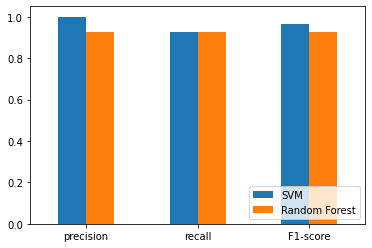

In [57]:
SVM_metrics = np.array([SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_precision, RF_recall, RF_f1_score])
index = ['precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

Now lets take a look at ROC curve. This will show what classifiers are working better depending on the data being run. 

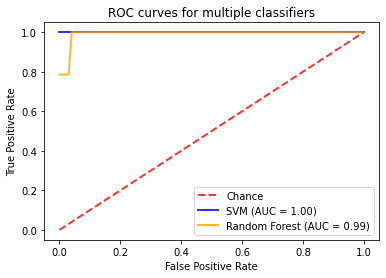

In [58]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

In this sample above, SVM has performed better than Random Forest with a better F1 score.
SVM is the best performing algorithim tested, But overall they all perform quite well at a good steady standard. 

### TASK 3

### Third Classifier

KNN will be my third classifier

As for the same steps made above:
1. Below we will create a pipline & prepare a prameter grid.
2. svm__ can be used to specify the name of a parameter for a specific element.
3. Futhermore, this just not full list of svn.SVC and it's possible values.

In [59]:
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])


param_grid = {
    'knn__n_neighbors' : [2,3,4,5,6,7,8,9,10],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric' : ['euclidean','manhattan','chebyshev','minkowski']
}


search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params & model for later to be used.
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.959:
Best parameters:  {'knn__metric': 'euclidean', 'knn__n_neighbors': 4, 'knn__weights': 'uniform'}


From here we will look at the models over the key metrics & different comparisons.

In [60]:
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)

KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])

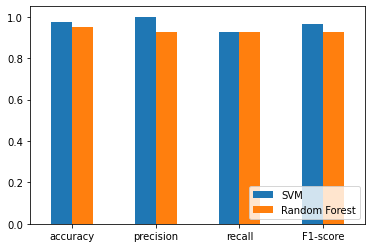

In [61]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

As "accuracy" is now added as shown above. 

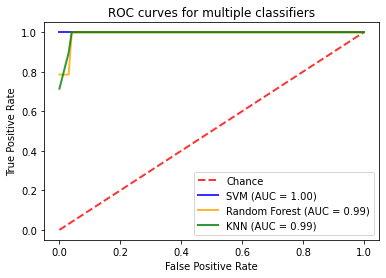

In [62]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='green', label='KNN (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

As shown above SVM still looks like the best algorithm for performance.


This can change depending on how many times you run the above code. Very interesting to see this overall. 

### Train a Final Model

Finally, we can train an SVM model with all data we have, assuming that the more data we have the better the model.

In [63]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [64]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

Done-

Thanks for taking the time to go through my work. 